In [1]:
import autograd

In [2]:
from __future__ import absolute_import
from __future__ import print_function
import matplotlib.pyplot as plt

import autograd.numpy as np
import autograd.numpy.random as npr
import autograd.scipy.stats.multivariate_normal as mvn
import autograd.scipy.stats.norm as norm

from autograd import grad
from autograd.optimizers import adam


def black_box_variational_inference(logprob, D, num_samples):
    """Implements http://arxiv.org/abs/1401.0118, and uses the
    local reparameterization trick from http://arxiv.org/abs/1506.02557"""

    def unpack_latent_params(params):
        # Variational dist is a diagonal Gaussian.
        mean, log_std = params[:D], params[D:]
        return mean, log_std

    def gaussian_entropy(log_std):
        return 0.5 * D * (1.0 + np.log(2*np.pi)) + np.sum(log_std)

    rs = npr.RandomState(0)
    def variational_objective(latent_params, x):
        """Provides a stochastic estimate of the variational lower bound."""
        mean, log_std = unpack_latent_params(latent_params)
        samples = rs.randn(num_samples, D) * np.exp(log_std) + mean
        lower_bound = gaussian_entropy(log_std) + np.mean(logprob(samples, x))
        return -lower_bound

    gradient = grad(variational_objective)

    return variational_objective, gradient, unpack_latent_params


In [3]:
%matplotlib inline
from IPython import display

def plot_isocontours(func, xlimits=[-2, 2], ylimits=[-4, 2], numticks=101):
     x = np.linspace(*xlimits, num=numticks)
     y = np.linspace(*ylimits, num=numticks)
     X, Y = np.meshgrid(x, y)
     zs = func(np.concatenate([np.atleast_2d(X.ravel()), np.atleast_2d(Y.ravel())]).T)
     Z = zs.reshape(X.shape)
     plt.contour(X, Y, Z)

def callback(params, t, g):
    print("Iteration {} lower bound {}".format(t, -objective(params, t)))
    plt.clf()

    target_distribution = lambda x : np.exp(log_density(x, t))
    plot_isocontours(target_distribution)

    mean, log_std = unpack_params(params)
    variational_contour = lambda x: mvn.pdf(x, mean, np.diag(np.exp(2*log_std)))
    plot_isocontours(variational_contour)
    plt.pause(1.0/30.0)

    display.clear_output(wait=True)
    display.display(plt.gcf())


In [4]:
# Specify an inference problem by its unnormalized log-density.
D = 2
def log_density(Z, X):
    #Variables naming here is misleading
    #mu, log_sigma = Z[:, 0], Z[:, 1]
    #sigma_density = norm.logpdf(log_sigma, 0, 1.35)
    #mu_density = norm.logpdf(mu, 0, np.exp(log_sigma))
    z1, z2 = Z[:, 0], Z[:, 1]
    z2_density = norm.logpdf(z2, 0, 1.35)
    z1_density = norm.logpdf(z1, 0, np.exp(z2))        
    return z1_density + z2_density

# Build variational objective.
objective, gradient, unpack_params = black_box_variational_inference(log_density, D, num_samples=2000)
        
init_mean    = -1 * np.ones(D)
init_log_std = -5 * np.ones(D)
init_var_params = np.concatenate([init_mean, init_log_std])
print(init_var_params)

[-1. -1. -5. -5.]


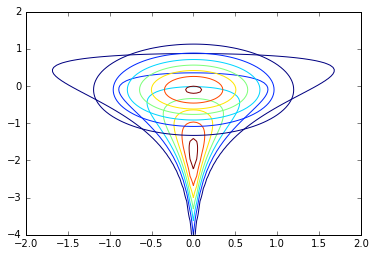

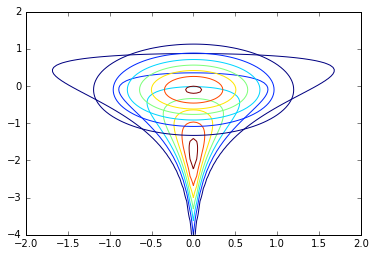

In [6]:
print("Optimizing variational parameters...")
variational_params = adam(gradient, init_var_params, step_size=0.1, num_iters=100, callback=callback)

In [33]:
print(variational_params)

[ 0.00424797 -0.09028569 -0.50743086 -0.48357195]
